In [1]:
import pandas as pd
from pandas import option_context
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
set_config(transform_output = "pandas")

#Classifier
from sklearn.ensemble import GradientBoostingClassifier

#saving the trained model
import skops.io as sio

#feature importance calculation
from sklearn.feature_selection import RFECV

#MissingIndicator, Imputer and Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
RAND_SEED = 7
SPLIT = 0.4

## Read the features and their ground truth along with dataset they come from

In [3]:
df_features_read = pd.read_csv('../data/features0305.csv',index_col=0).sort_index()

In [4]:
ground_truth = pd.read_csv('../data/total_contributors_with_dataset.csv').set_index('contributor')

In [5]:
df_features = (
               df_features_read
               .merge(ground_truth.drop('dataset',axis=1), left_index=True, right_index=True)
               .assign(bot = lambda d: np.where(d.acc_type_y == "human", 0, 1))
               .drop(['acc_type_x', 'acc_type_y'],axis=1)
               .assign(contributor = lambda d: d.index.str.replace('[bot]','',regex=False))
               .set_index('contributor')
               .sort_index()
              )
with option_context('display.max_column',None):
    display(df_features.query('bot == 1'))

,feat_num_activities,feat_num_activity_type,feat_repos,feat_owner,feat_ratio_owner_repo,consecutive_activity_time_mean,consecutive_activity_time_50%,consecutive_activity_time_std,consecutive_activity_time_gini,consecutive_activity_time_IQR,activity_per_repo_mean,activity_per_repo_50%,activity_per_repo_std,activity_per_repo_gini,activity_per_repo_IQR,activity_type_per_repo_mean,activity_type_per_repo_50%,activity_type_per_repo_std,activity_type_per_repo_gini,activity_type_per_repo_IQR,continuous_activity_repo_mean,continuous_activity_repo_50%,continuous_activity_repo_std,continuous_activity_repo_gini,continuous_activity_repo_IQR,time_spent_in_repo_mean,time_spent_in_repo_50%,time_spent_in_repo_std,time_spent_in_repo_gini,time_spent_in_repo_IQR,time_to_switch_repo_mean,time_to_switch_repo_50%,time_to_switch_repo_std,time_to_switch_repo_gini,time_to_switch_repo_IQR,time_to_switch_act_type_mean,time_to_switch_act_type_50%,time_to_switch_act_type_std,time_to_switch_act_type_gini,time_to_switch_act_type_IQR,activity_per_act_type_mean,activity_per_act_type_50%,activity_per_act_type_std,activity_per_act_type_gini,activity_per_act_type_IQR,bot
contributor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1gtm,299,3,23,4,0.174,0.081,0.000,0.679,0.970,0.003,13.000,8.0,13.655,0.490,10.00,1.957,2.0,0.367,0.062,0.0,6.795,3.0,9.849,0.567,4.25,0.206,0.001,1.275,0.956,0.010,0.352,0.017,1.212,0.897,0.045,0.017,0.000,0.191,0.950,0.001,99.667,146.0,85.500,0.337,75.50,1
24emebot,279,1,1,1,1.000,7.589,0.584,15.767,0.786,6.146,279.000,279.0,0.000,0.000,0.00,1.000,1.0,0.000,0.000,0.0,279.000,279.0,0.000,0.000,0.00,2109.750,2109.750,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,NaN,NaN,0.000,0.000,NaN,279.000,279.0,0.000,0.000,0.00,1
47erbot,201,7,12,3,0.250,1.930,0.003,9.800,0.960,0.012,16.750,12.0,15.058,0.392,8.50,4.667,5.0,1.231,0.095,0.0,2.871,3.0,1.710,0.275,1.00,1.237,0.000,7.341,0.965,0.004,4.339,0.012,14.939,0.927,0.020,2.013,0.001,10.149,0.958,0.010,28.714,31.0,12.945,0.215,6.50,1
5imon-bot,56,1,3,1,0.333,36.690,0.311,76.716,0.813,26.075,18.667,8.0,19.348,0.405,17.00,1.000,1.0,0.000,0.000,0.0,4.308,1.0,8.430,0.629,2.00,33.451,0.000,62.265,0.519,45.408,131.922,114.406,115.178,0.456,134.859,NaN,NaN,0.000,0.000,NaN,56.000,56.0,0.000,0.000,0.00,1
9cibot,27,2,1,1,1.000,38.672,0.097,112.949,0.864,0.215,27.000,27.0,0.000,0.000,0.00,2.000,2.0,0.000,0.000,0.0,27.000,27.0,0.000,0.000,0.00,1005.467,1005.467,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,10.420,0.048,41.244,0.884,0.102,13.500,13.5,7.778,0.204,5.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zksync-admin-bot2,51,4,5,1,0.200,41.947,0.560,97.237,0.820,39.724,10.200,3.0,11.584,0.518,14.00,2.400,2.0,0.548,0.100,1.0,3.923,3.0,3.201,0.395,3.00,34.610,0.196,94.986,0.827,12.673,137.286,86.892,159.089,0.535,95.312,43.350,0.095,108.175,0.848,13.403,12.750,13.5,5.909,0.221,5.75,1
zorro-bot,85,3,1,1,1.000,25.382,11.938,39.925,0.660,26.623,85.000,85.0,0.000,0.000,0.00,3.000,3.0,0.000,0.000,0.0,85.000,85.0,0.000,0.000,0.00,2132.089,2132.089,0.000,0.000,0.000,NaN,NaN,0.000,0.000,NaN,30.598,17.293,41.522,0.584,30.556,28.333,8.0,38.734,0.541,34.50,1
zube,43,3,7,5,0.714,12.025,1.843,21.076,0.746,12.083,6.143,1.0,7.034,0.545,9.50,1.429,1.0,0.535,0.171,1.0,2.389,1.0,2.429,0.443,1.00,9.460,0.000,26.561,0.717,0.015,19.693,6.962,28.264,0.655,14.387,12.800,6.231,21.420,0.698,6.705,14.333,4.0,19.655,0.543,17.50,1


In [6]:
df_features.columns[df_features.isna().any()]

Index(['time_to_switch_repo_mean', 'time_to_switch_repo_50%',
       'time_to_switch_repo_IQR', 'time_to_switch_act_type_mean',
       'time_to_switch_act_type_50%', 'time_to_switch_act_type_IQR'],
      dtype='object')

In [7]:
df_features.bot.value_counts()

0    1115
1    1035
Name: bot, dtype: int64

In [8]:
def data_split(df):
    '''
    args: df - DataFrame; features representing contirbutor ativities
    
    return: x_train - DataFrame; features for training the model
            y_train - DataFrame; labels that represent bot/human for trianing the model
            x_test - DataFrame; features for testing the model
            y_test - DataFrame; labels that represent bot/human for testing the model
    
    method: invoke train_test_split to split the data and the labels accordingly
    '''
    
    x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], 
                                                        df.iloc[:,-1:], 
                                                        test_size=SPLIT, 
                                                        random_state=RAND_SEED,
                                                        stratify=df.iloc[:,-1:])
    
    return(x_train, x_test, y_train, y_test)

In [9]:
x_train, x_test, y_train, y_test = data_split(df_features.drop('dataset',axis=1))

In [10]:
total = df_features.shape[0]
bot = df_features.query('bot == 1').shape[0]
hum = df_features.query('bot == 0').shape[0]

print(f'original data: \n   total number of contributors: {total} \n   bot contributors: {bot} \n   human contributors: {hum}')

tr_total = y_train.shape[0]
tr_bot = y_train.query('bot == 1').shape[0]
tr_hum = y_train.query('bot == 0').shape[0]

print(f'\ntrain data: \n   total number of contributors: {tr_total} \n   bot contributors: {tr_bot} \n   human contributors: {tr_hum}')

print(f'\ntraining proportion: \n   total number of contributors: {tr_total/total} \n   bot contributors: {tr_bot/bot} \n   human contributors: {tr_hum/hum}')

te_total = y_test.shape[0]
te_bot = y_test.query('bot == 1').shape[0]
te_hum = y_test.query('bot == 0').shape[0]

print(f'\ntest data: \n   total number of contributors: {te_total} \n   bot contributors: {te_bot} \n   human contributors: {te_hum}')

original data: 
   total number of contributors: 2150 
   bot contributors: 1035 
   human contributors: 1115

train data: 
   total number of contributors: 1290 
   bot contributors: 621 
   human contributors: 669

training proportion: 
   total number of contributors: 0.6 
   bot contributors: 0.6 
   human contributors: 0.6

test data: 
   total number of contributors: 860 
   bot contributors: 414 
   human contributors: 446


## Features and labels

In [9]:
x_train = pd.read_csv('../data/train_feat.csv',index_col=0)
y_train = pd.read_csv('../data/train_label.csv',index_col=0)
x_test = pd.read_csv('../data/test_feat.csv',index_col=0)
y_test = pd.read_csv('../data/test_label.csv',index_col=0)

In [10]:
x_train.shape

(1290, 45)

## Pipeline construction

In [11]:
def make_nested_imputers(df):
    '''
    args: df - DataFrame; contributor behavioural features
    
    returns: preprocessor - ColumnTransformer that specifies all the indicator, imputers
    
    method: Define all the individual indicator and imputers and give it to the column transformer 
            in the form of list of tuples. Each tuple is of the form 
            ('transformer name', 'transformer', 'column names')  
    '''
    
    #indicator and imputer
    imputers = {'nan_indicator': MissingIndicator(missing_values=np.nan, features='all'),
                'nan_imputer': SimpleImputer(missing_values=np.nan, strategy='median', 
                                             keep_empty_features = True)
               }
    
    #names for indicator and imputers
    imputer_names = {'nan_indicator': 'indicate_nan',
                     'nan_imputer': 'impute_nan'
                    }
    
    #group of columns to be used in indicator and imputers

    nan_col_names = df.columns[df.isna().any()].to_list()
    
    nested_transformers = [(imputer_names[imputer], imputers[imputer], nan_col_names) 
                           for imputer in imputers]
    preprocessor = ColumnTransformer(transformers=nested_transformers,
                                     remainder='passthrough',
                                     verbose_feature_names_out=False)
    return(preprocessor)

In [12]:
def make_custom_pipeline(df, clf=None, with_clf=True):
    '''
    args: df - DataFrame; contributor behavioural features
          clf - method; classifier to be used
          with_clf - bool; To include the estimator (classifier) in the pipeline 
                           (True) or just the data transformation
    
    returns: pipe - Pipeline of transformers to be applied on the data
    
    method: invoke make_nested_imputers for getting all the transformations that has to applied on 
            the data and build the pipeline with nested transformations and classifier
    '''
    
    preprocessor = make_nested_imputers(df)
    if(with_clf == True):
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('clf', clf)
        ])
    else:
        pipe = Pipeline([
            ('preprocessor', preprocessor)])
    
    return(pipe)

## Getting important features using RFECV

In [13]:
model = GradientBoostingClassifier(random_state=RAND_SEED,
                                   criterion='friedman_mse',
                                   loss='log_loss',
                                   learning_rate=0.05,
                                   max_depth=3,
                                   max_features='log2',
                                   n_estimators=100)
rfecv = RFECV(estimator=model, 
              step=1,
              min_features_to_select=1,
              cv=StratifiedShuffleSplit(10, random_state=RAND_SEED),
              scoring='f1_weighted',
              n_jobs=-1)
rfecv.fit(x_train.fillna(-1), y_train['bot'].values) # cannot pass pipe as internally df is converted to ndarray and col names are not valid anymore.

RFECV(cv=StratifiedShuffleSplit(n_splits=10, random_state=7, test_size=None,
            train_size=None),
      estimator=GradientBoostingClassifier(learning_rate=0.05,
                                           max_features='log2',
                                           random_state=7),
      n_jobs=-1, scoring='f1_weighted')

In [14]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 38


In [15]:
'''
Important features
'''
RFECV_impt = (
    pd.DataFrame(rfecv.feature_names_in_,columns=['feature'])
    .join(pd.DataFrame(rfecv.ranking_,columns=['rank']))
    .query('rank==1')
    .reset_index(drop=True)
)
RFECV_impt

,feature,rank
0,feat_num_activities,1
1,feat_num_activity_type,1
2,feat_owner,1
3,feat_ratio_owner_repo,1
4,consecutive_activity_time_mean,1
5,consecutive_activity_time_50%,1
6,consecutive_activity_time_std,1
7,consecutive_activity_time_gini,1
8,activity_per_repo_mean,1
9,activity_per_repo_50%,1


In [16]:
'''
Important features:
NT: feat_num_activities
NA: feat_num_activity_type
NOR: feat_owner
ORR: feat_ratio_owner_repo

DCA: consecutive_activity_time - mean, median, std, gini
NAR: activity_per_repo - mean, median, gini, IQR
NTR: activity_type_per_repo - mean, median, std, gini
NCAR: continuous_activity_repo - mean, std, IQR
DCAR: time_spent_in_repo - mean, median, std, IQR
DAAR: time_to_switch_repo - mean, median, std, gini, IQR
DCAT: time_to_switch_act_type - mean, median, std, gini, IQR
NAT: activity_per_act_type - mean, median, std, gini, IQR
'''

'\nMissing features:\nNT: feat_num_activities\nNA: feat_num_activity_type\nNOR: feat_owner\nORR: feat_ratio_owner_repo\n\nDCA: consecutive_activity_time - mean, median, std, gini\nNAR: activity_per_repo - mean, median, gini, IQR\nNTR: activity_type_per_repo - mean, median, std, gini\nNCAR: continuous_activity_repo - mean, std, IQR\nDCAR: time_spent_in_repo - mean, median, std, IQR\nDAAR: time_to_switch_repo - mean, median, std, gini, IQR\nDCAT: time_to_switch_act_type - mean, median, std, gini, IQR\nNAT: activity_per_act_type - mean, median, std, gini, IQR\n'

(0.0, 45.0)

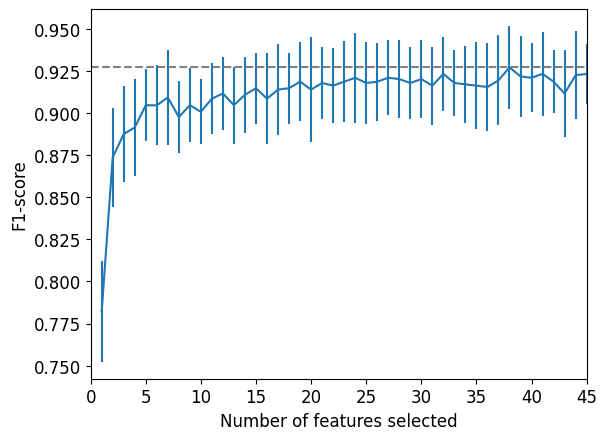

In [17]:
rfecv_results = pd.DataFrame(rfecv.cv_results_)

plt.figure()
plt.xlabel("Number of features selected",fontsize=12)
plt.ylabel("F1-score",fontsize=12)
plt.errorbar(
    x=rfecv_results.index+1,
    y=rfecv_results["mean_test_score"],
    yerr=rfecv_results["std_test_score"],
    label='F1-score'
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=rfecv_results["mean_test_score"].max(), color='gray', linestyle='--')
plt.xlim(0,45)

## BIMBAS - Bot Identification Model Based on Activity Sequences

### Mapping feature names to their abbreviations given in the paper

In [18]:
columns = {'feat_num_activities':'NA',
           'feat_num_activity_type':'NT',
           'feat_repos':'NR',
           'feat_owner':'NOR',
           'feat_ratio_owner_repo':'ORR',
           
           'consecutive_activity_time_mean':'DCA_mean',
           'consecutive_activity_time_50%':'DCA_median',
           'consecutive_activity_time_std':'DCA_std',
           'consecutive_activity_time_gini':'DCA_gini',
           'consecutive_activity_time_IQR':'DCAR_IQR',
           
           'activity_per_repo_mean':'NAR_mean',
           'activity_per_repo_50%':'NAR_median',
           'activity_per_repo_std':'NAR_std',
           'activity_per_repo_gini':'NAR_gini',
           'activity_per_repo_IQR':'NAR_IQR',
           
           'activity_type_per_repo_mean':'NTR_mean',
           'activity_type_per_repo_50%':'NTR_median',
           'activity_type_per_repo_std':'NTR_std',
           'activity_type_per_repo_gini':'NTR_gini',
           'activity_type_per_repo_IQR':'NTR_IQR',
           
           'continuous_activity_repo_mean':'NCAR_mean',
           'continuous_activity_repo_50%':'NCAR_median',
           'continuous_activity_repo_std':'NCAR_std',
           'continuous_activity_repo_gini':'NCAR_gini',
           'continuous_activity_repo_IQR':'NCAR_IQR',
           
           'time_spent_in_repo_mean':'DCAR_mean',
           'time_spent_in_repo_50%':'DCAR_median',
           'time_spent_in_repo_std':'DCAR_std',
           'time_spent_in_repo_gini':'DCAR_gini',
           'time_spent_in_repo_IQR':'DCAR_IQR',
           
           'time_to_switch_repo_mean':'DAAR_mean',
           'time_to_switch_repo_50%':'DAAR_median',
           'time_to_switch_repo_std':'DAAR_std',
           'time_to_switch_repo_gini':'DAAR_gini',
           'time_to_switch_repo_IQR':'DAAR_IQR',
           
           'time_to_switch_act_type_mean':'DCAT_mean',
           'time_to_switch_act_type_50%':'DCAT_median',
           'time_to_switch_act_type_std':'DCAT_std',
           'time_to_switch_act_type_gini':'DCAT_gini',
           'time_to_switch_act_type_IQR':'DCAT_IQR',
           
           'activity_per_act_type_mean':'NAT_mean',
           'activity_per_act_type_50%':'NAT_median',
           'activity_per_act_type_std':'NAT_std',
           'activity_per_act_type_gini':'NAT_gini',
           'activity_per_act_type_IQR':'NAT_IQR'}

### Select the important features in the training set

In [33]:
x_train, x_test, y_train, y_test = data_split(df_features_important_perm)

In [ ]:
'time_to_switch_repo_mean', 'time_to_switch_repo_50%',
'time_to_switch_repo_IQR', 'time_to_switch_act_type_mean',
'time_to_switch_act_type_50%', 'time_to_switch_act_type_IQR'

In [19]:
important_features_perm_REFCV = RFECV_impt.feature.to_list()

x_train_impt = (
    x_train
    [important_features_perm_REFCV]
    .rename(columns=columns)
)
x_train_impt

,NA,NT,NOR,ORR,DCA_mean,DCA_median,DCA_std,DCA_gini,NAR_mean,NAR_median,...,DCAT_mean,DCAT_median,DCAT_std,DCAT_gini,DCAT_IQR,NAT_mean,NAT_median,NAT_std,NAT_gini,NAT_IQR
contributor,,,,,,,,,,,,,,,,,,,,,
kaczmarj,134,12,18,0.857,15.029,0.111,47.043,0.888,6.381,1.0,...,12.948,0.119,37.243,0.894,0.828,11.167,8.0,9.379,0.412,7.50
plasmapy-requirements-bot[bot],26,3,1,1.000,80.640,0.001,85.685,0.458,26.000,26.0,...,76.721,0.001,85.209,0.478,167.996,8.667,9.0,3.512,0.179,3.50
accesslint[bot],192,1,30,1.000,8.043,0.000,24.684,0.747,6.400,3.0,...,NaN,NaN,0.000,0.000,NaN,192.000,192.0,0.000,0.000,0.00
blueztestbot,300,6,2,0.500,0.732,0.000,2.133,0.821,75.000,51.5,...,0.662,0.000,2.212,0.834,0.155,50.000,56.0,26.796,0.258,19.75
thundernest-bot,300,1,1,1.000,1.039,0.201,2.128,0.706,300.000,300.0,...,NaN,NaN,0.000,0.000,NaN,300.000,300.0,0.000,0.000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wingetbot,193,5,2,1.000,0.051,0.001,0.157,0.857,96.500,96.5,...,0.011,0.000,0.052,0.898,0.000,38.600,25.0,47.967,0.564,40.00
roxbot,299,6,1,0.125,3.991,1.923,5.600,0.654,37.375,8.5,...,4.756,1.258,6.790,0.686,7.781,49.833,21.5,73.262,0.614,37.75
josemduarte,218,14,7,0.212,8.984,0.121,32.782,0.908,6.606,1.0,...,11.581,0.107,39.529,0.904,1.951,15.571,6.5,30.071,0.654,11.25


### Train and export the pipeline with important features

In [20]:
model = GradientBoostingClassifier(random_state=RAND_SEED,
                                   criterion='friedman_mse',
                                   loss='log_loss',
                                   learning_rate=0.05,
                                   max_depth=3,
                                   max_features='log2',
                                   n_estimators=100)
pipe = make_custom_pipeline(x_train_impt, model)
pipe.fit(x_train_impt,y_train['bot'].values)
obj = sio.dump(pipe, 'bimbas.skops')